In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
import pandas as pd
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

/home/Jagan/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [2]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave

In [3]:
from PIL import Image

In [4]:
image = Image.open('woman.jpg')

In [5]:
image.format, image.size, image.mode

('PNG', (400, 400), 'RGBA')

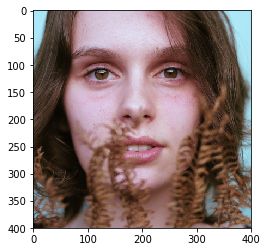

In [6]:
plt.imshow(image)

In [7]:
from torchvision.transforms import Lambda

In [8]:
def transform_rgb2lab(image):
    image = image.convert("RGB")
    image = np.asarray(image)
    image = rgb2lab(image/255)
    return image

In [9]:
transform = transforms.Compose([Lambda(lambda image: transform_rgb2lab(image)),
                                transforms.ToTensor()
                               ])

In [10]:
image = transform(image)

In [11]:
image.shape

torch.Size([3, 400, 400])

In [12]:
pd.Series(np.squeeze(image.numpy().reshape(-1,1))).describe()

count    480000.000000
mean         20.248759
std          23.238496
min         -17.894492
25%           5.796703
50%          13.818518
75%          25.664605
max          90.485881
dtype: float64

In [13]:
pd.Series(np.squeeze(image.numpy()[0].reshape(-1,1))).describe()

count    160000.000000
mean         44.008792
std          24.602545
min           1.291720
25%          24.541595
50%          40.714107
75%          65.781454
max          90.485881
dtype: float64

In [14]:
pd.Series(np.squeeze(image.numpy()[1:].reshape(-1,1))).describe()

count    320000.000000
mean          8.368743
std           9.164879
min         -17.894492
25%           2.752984
50%           9.899875
75%          14.900360
max          40.266128
dtype: float64

In [15]:
X = image[0,:,:]
Y = image[1:,:,:]/128

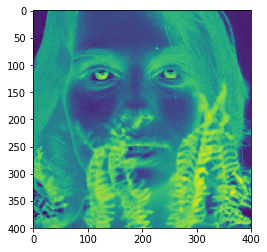

In [16]:
plt.imshow(Y[1])

In [17]:
import torch.nn.functional as F

- The weights are `xavier_uniform` == `glorot_uniform` in Keras
- The default bias in Keras is 0.

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [19]:
class ColorNetAlpha(nn.Module):
    def __init__(self):
        super(ColorNetAlpha, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (3,3), stride=2)
        self.conv2 = nn.Conv2d(8, 8, (3,3), stride=1)
        self.conv3 = nn.Conv2d(8, 16, (3,3), stride=1)
        self.conv4 = nn.Conv2d(16, 16, (3,3), stride=2)
        self.conv5 = nn.Conv2d(16, 32, (3,3), stride=1)
        self.conv6 = nn.Conv2d(32, 32, (3,3), stride=2)
        self.upsample7 = nn.Upsample(scale_factor=(2,2))
        self.conv8 = nn.Conv2d(32, 32, (3,3), stride=1)
        self.upsample9 = nn.Upsample(scale_factor=(2,2))
        self.conv10 = nn.Conv2d(32, 16, (3,3), stride=1)
        self.upsample11 = nn.Upsample(scale_factor=(2,2))
        self.conv12 = nn.Conv2d(16, 2, (3,3), stride=1)
   
    def same_pad(self, input, k=(3,3), d=(1,1), s=(1,1)):
        
        i = (input.size(-2), input.size(-1))
        # i = (i_H, i_W)
        # k = (k_H, k_W)
        # d = (d, d); dilation
        # s = (s, s); stride
        
        # tensorflow style - same padding output calculation
        calc_eff_k = lambda k, d: (k - 1) * d + 1
        k = tuple([calc_eff_k(x, y) for x, y in zip(k, d)])
        calc_o = lambda i, s: np.ceil(i/s)
        o = tuple([calc_o(x, y) for x, y in zip(i, s)])
        calc_p = lambda o, s, k, i: max(0, (o-1)*s + k-i)
        p = tuple([calc_p(w, x, y, z) for w, x, y, z in zip(o, s, k, i)])
                               
        # left, right , up , bottom
        padding = [p[1]//2, p[1]//2 + p[1]%2, p[0]//2, p[0]//2 + p[0]%2]
        padding = [int(p) for p in padding]
        return F.pad(input, padding)

    def forward(self, x):
        x = F.relu(self.conv1(self.same_pad(x, s=(2, 2))))
        x = F.relu(self.conv2(self.same_pad(x)))
        x = F.relu(self.conv3(self.same_pad(x)))
        x = F.relu(self.conv4(self.same_pad(x, s=(2, 2))))
        x = F.relu(self.conv5(self.same_pad(x)))
        x = F.relu(self.conv6(self.same_pad(x, s=(2, 2))))
        x = self.upsample7(x)
        x = F.relu(self.conv8(self.same_pad(x)))
        x = self.upsample9(x)
        x = F.relu(self.conv10(self.same_pad(x)))
        x = self.upsample11(x)
        x = torch.tanh(self.conv12(self.same_pad(x)))
        
        return x

In [20]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [21]:
net = ColorNetAlpha()

In [22]:
net.apply(weights_init)

ColorNetAlpha(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (upsample7): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (upsample9): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (upsample11): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv12): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1))
)

In [23]:
net.to(device)

ColorNetAlpha(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (upsample7): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (upsample9): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (upsample11): Upsample(scale_factor=(2, 2), mode=nearest)
  (conv12): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1))
)

In [24]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0005, momentum=0.9)

### Training Loop

In [25]:
from tqdm import tqdm

In [26]:
for epoch in tqdm(range(100)):  
    running_loss = 0.0
    # get the inputs
    inputs, labels = X.view(1, 1, 400, 400).float(), Y.view(1, 2 , 400, 400).float()
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 5 == 4:    # print every 4 epochs
        print(f'epoch: {epoch + 1}, loss: {running_loss / 4}')
        running_loss = 0.0

print('Finished Training')

  0%|          | 0/100 [00:00<?, ?it/s]/home/Jagan/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
 11%|█         | 11/100 [00:00<00:01, 50.16it/s]

epoch: 5, loss: 0.0022222199477255344
epoch: 10, loss: 0.0018499689176678658
epoch: 15, loss: 0.0015213193837553263


 29%|██▉       | 29/100 [00:00<00:01, 51.67it/s]

epoch: 20, loss: 0.0013261301210150123
epoch: 25, loss: 0.0012667614500969648
epoch: 30, loss: 0.0012674860190600157


 41%|████      | 41/100 [00:00<00:01, 52.10it/s]

epoch: 35, loss: 0.0012700972147285938
epoch: 40, loss: 0.0012599433539435267
epoch: 45, loss: 0.0012461814330890775


 59%|█████▉    | 59/100 [00:01<00:00, 52.48it/s]

epoch: 50, loss: 0.0012378639075905085
epoch: 55, loss: 0.0012357465457171202
epoch: 60, loss: 0.0012361390981823206


 71%|███████   | 71/100 [00:01<00:00, 52.57it/s]

epoch: 65, loss: 0.0012362344423308969
epoch: 70, loss: 0.0012356225633993745
epoch: 75, loss: 0.0012349835596978664


 89%|████████▉ | 89/100 [00:01<00:00, 52.75it/s]

epoch: 80, loss: 0.0012347219744697213
epoch: 85, loss: 0.0012347244191914797
epoch: 90, loss: 0.001234753173775971


100%|██████████| 100/100 [00:01<00:00, 52.76it/s]

epoch: 95, loss: 0.0012347246520221233
epoch: 100, loss: 0.0012346799485385418
Finished Training


### Test

In [27]:
inf_img = transform(Image.open('woman.jpg'))
X_inf = inf_img[0,:,:]
# Y_inf = inf_img[1:,:,:]/128
Y_pred = net(X_inf.view(1, 1, 400, 400).float().to(device))

X_inf = X_inf.to("cpu").numpy().reshape(400, 400, 1)
Y_pred = Y_pred.detach().to("cpu").numpy().reshape(400, 400, 2) * 128

# Output colorizations
output = np.empty(shape=(400, 400, 3))
output[:,:,0] = np.squeeze(X_inf)
output[:,:,1:] = Y_pred

imsave("img_result_py.png", lab2rgb(output))

/home/Jagan/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/Jagan/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


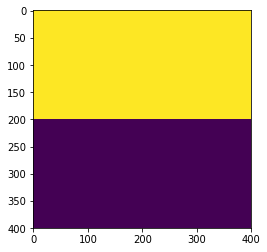

In [28]:
plt.imshow(Y_pred[:,:,1])